In [1]:
import os
import sys
import time
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
sys.path.append('/Users/yantingting/PycharmProjects/modeling/')
import database_conncet as data_con
import data_processing as dp
import summary_statistics as ss
from data_io_utils import *
from matplotlib.pyplot import MultipleLocator

In [2]:
file_path = '/Users/yantingting/Documents/用户画像(印尼)/用户分层/数据处理/'
if not os.path.exists(file_path):
    os.makedirs(file_path)

# 取数

In [10]:
query1= '''
select customer_id,
min(date(apply_time)) as first_apply_date,
max(date(apply_time)) as last_apply_date,
max(date_part('days',date('2020-02-18') - apply_time) ) first_apply_now,
min(date_part('days',date('2020-02-18') - apply_time)) last_apply_now,
count(distinct case when loan_status = 'DENIED' then id end ) as cnt_denied,
count(distinct case when loan_status = 'RESCIND' then id end ) as cnt_rescind,
count(distinct case when loan_status = 'APPROVED' or loan_status = 'FUNDED' or loan_status = 'CREATED' or loan_status = 'COLLECTION' then id end) as new_flag,
count(distinct case when loan_status = 'ADVANCE_PAIDOFF'  then id end) as cnt_advance,
count(distinct case when loan_status = 'PAIDOFF'  then id end) as cnt_paidoff,
count(distinct case when loan_status = 'COLLECTION'  then id end) as cnt_collection,
count(distinct case when loan_status = 'COLLECTION_PAIDOFF'  then id end) as cnt_collectionpaid,
count(distinct loan_no ) as cnt_apply,
count(distinct case when effective_date != '1970-01-01' then loan_no else null end ) as cnt_loan,
sum(case when effective_date != '1970-01-01' then extend_times else 0 end) cnt_extend,
max(case when effective_date != '1970-01-01' then extend_times else 0 end) max_extend,
min(case when effective_date !='1970-01-01' and effective_date is not null then effective_date else null end ) as first_effective_date,
max(case when effective_date !='1970-01-01' and effective_date is not null then effective_date else null end ) as last_effective_date,
max(case when effective_date !='1970-01-01' and effective_date is not null then date('2020-02-18') - effective_date else null end) first_effective_now,
min(case when effective_date !='1970-01-01' and effective_date is not null then date('2020-02-18') - effective_date else null end) last_effective_now,
count(distinct case when date('2020-02-18') - effective_date<=90 and  effective_date!= '1970-01-01' then loan_no else null end ) cnt_loan_90d,
count(distinct case when date('2020-02-18') - effective_date<=180 and  effective_date!= '1970-01-01' then loan_no else null end ) cnt_loan_180d
from dw_gocash_go_cash_loan_gocash_core_loan
where date(apply_time)<='2020-02-18'
group by customer_id;
'''

In [11]:
df1 =  data_con.database_gn(query1)
save_data_to_pickle(df1, file_path, '历史行为.pkl')
df1.shape
df1.head()

Successful connection


(939761, 22)

,customer_id,first_apply_date,last_apply_date,first_apply_now,last_apply_now,cnt_denied,cnt_rescind,new_flag,cnt_advance,cnt_paidoff,cnt_collection,cnt_collectionpaid,cnt_apply,cnt_loan,cnt_extend,max_extend,first_effective_date,last_effective_date,first_effective_now,last_effective_now,cnt_loan_90d,cnt_loan_180d
0,141218523654787072,2017-11-25,2017-12-28,814.0,781.0,2,0,0,1,0,0,0,3,1,0,0,2017-11-25,2017-11-25,815.0,815.0,0,0
1,141232347443232768,2017-10-23,2017-10-23,847.0,847.0,0,0,0,0,1,0,0,1,1,0,0,2017-10-24,2017-10-24,847.0,847.0,0,0
2,141234749319806976,2017-11-30,2017-11-30,809.0,809.0,0,0,1,0,0,1,0,1,1,0,0,2017-12-09,2017-12-09,801.0,801.0,0,0
3,141243827437834240,2017-11-25,2018-02-07,814.0,740.0,2,0,0,0,0,0,0,2,0,0,0,None,None,NaN,NaN,0,0
4,141252256982237184,2017-11-26,2017-11-26,813.0,813.0,1,0,0,0,0,0,0,1,0,0,0,None,None,NaN,NaN,0,0


In [ ]:
query2 = '''
select *,
case when last_paid_off_time !='1970-01-01' and last_paid_off_time is not null then date('2020-02-18') - date(last_paid_off_time) else null end last_paid_now
from (
select t1.customer_id as customer_id,
sum(t2.extend_fee+t2.late_fee+t2.approved_principal-t2.approved_amount ) as profit,
max(t2.last_paid_off_time) as last_paid_off_time
from 
(select customer_id, min(effective_date) as first_effective_date
from dw_gocash_go_cash_loan_gocash_core_loan
where date(apply_time)<='2020-02-18'
group by customer_id)t1
left join 
(select a1.id as loan_id,
a1.customer_id as customer_id,
a1.effective_date,
a1.approved_principal,
a1.approved_amount,
a2.last_paid_off_time,
case when a2.extend_fee is not null then a2.extend_fee else 0 end as extend_fee,
case when a2.late_fee is not null then a2.late_fee else 0 end as late_fee,
case when a2.principal is not null then a2.principal else 0 end as principal_repay
from 
(select * from dw_gocash_go_cash_loan_gocash_core_loan
where effective_date is not null) a1 
left join 
(select loan_id,
sum(case when extend_fee is not null then extend_fee else 0 end)  as extend_fee,
sum(case when late_fee is not null then late_fee else 0 end)  as late_fee,
sum(case when principal is not null then principal else 0 end)  as principal,
max(case when date(paid_off_time) !='1970-01-01' then paid_off_time else null end) as last_paid_off_time
from dw_gocash_go_cash_loan_gocash_core_loan_pay_flow
where status = 'SUCCESS'
and date(create_time)<='2020-02-18'
group by loan_id)a2 
on a1.id = a2.loan_id) t2 
on t1.customer_id = t2.customer_id
group by t1.customer_id) t;
'''

In [58]:
df_profit = data_con.database_gn(query2)
save_data_to_pickle(df_profit, file_path, '盈利性.pkl')
df_profit.shape
df_profit.head()

Successful connection


(939761, 4)

,customer_id,profit,last_paid_off_time,last_paid_now
0,319419641822748672,3421200.0,2019-09-29 17:31:33,142.0
1,195182572838363136,625500.0,NaT,NaN
2,428240424871043072,31600.0,NaT,NaN
3,398068629904130048,253500.0,NaT,NaN
4,423206875474329600,229800.0,NaT,NaN


In [5]:
query3 = '''
select
	u.customer_id as customer_id,
	u.max_late_days,
	u.total_order,
	u.total_loan,
	u.rucui_loan,
	u.rucui_order,
	v.chucui_loan,
	v.chucui_order,
	v.chucui_days,
	v.max_chucui_days
from
	(
	select
		a.customer_id as customer_id,
		max(late_day) as max_late_days,
		count(*) as total_order,
		count(distinct a.id) as total_loan,
		count(distinct case when b.order_status is not null and b.order_status <> 'PAIDOFF' then a.id else null end) as rucui_loan,
		count(distinct case when b.order_status is not null and b.order_status <> 'PAIDOFF' then b.id else null end) as rucui_order
	from
		(
		select
			id,
			customer_id,
			approved_principal,
			approved_period,
			effective_date,
			return_flag
		from
			public.dw_gocash_go_cash_loan_gocash_core_loan
            where date(apply_time) <='2020-02-18'
		)a
	left join (
		select
			id,
			order_id,
			order_status,
			late_day,
			row_number() over(partition by order_id
		order by
			create_time) as rk
		from
			public.dw_gocash_gocash_collection_col_case)b on
		a.id = b.order_id
	group by
		a.customer_id)u
left join (
	select
		a.customer_id as customer_id,
		max(late_days) as max_chucui_days,
		sum(late_days) as chucui_days,
		count(distinct case when late_fee>0 then a.id else null end) as chucui_loan,
		count(distinct case when late_fee>0 then b.id else null end) as chucui_order
	from
		(
		select
			id,
			customer_id,
			approved_principal,
			approved_period,
			effective_date,
			return_flag
		from
			public.dw_gocash_go_cash_loan_gocash_core_loan
		)a
	left join (
		select
			id,
			loan_id,
			late_days,
			late_fee,
			row_number() over(partition by loan_id
		order by
			create_time) as rk
		from
			public.dw_gocash_go_cash_loan_gocash_core_loan_pay_flow
		where
			status = 'SUCCESS'
			and late_fee>0)b on
		a.id = b.loan_id
	group by
		a.customer_id) v 
		on	v.customer_id = u.customer_id
'''

In [6]:
df3 = data_con.database_gn(query3)
save_data_to_pickle(df3, file_path, '催收情况.pkl')
df3.shape
df3.head()

Successful connection


(939761, 10)

,customer_id,max_late_days,total_order,total_loan,rucui_loan,rucui_order,chucui_loan,chucui_order,chucui_days,max_chucui_days
0,141549829613821952,NaN,1,1,0,0,0,0,NaN,NaN
1,141617458365997056,NaN,1,1,0,0,0,0,NaN,NaN
2,141828449351630848,783.0,1,1,1,1,0,0,NaN,NaN
3,141837329116827648,712.0,2,2,1,1,1,1,1.0,1.0
4,141850255533932544,783.0,1,1,1,1,0,0,NaN,NaN


In [43]:
query4 = '''
select t1.id as customer_id,t1.cell_phone,
t1.create_time,
t1.update_time,
t1.idcard_pass_flag,
'注册未申请' as type
from dw_gocash_go_cash_loan_gocash_core_customer t1 
left join 
(select distinct customer_id from dw_gocash_go_cash_loan_gocash_core_loan where date(apply_time)<='2020-02-18') t2 
on t1.id = t2.customer_id
where t2.customer_id is null and date(t1.create_time)<='2020-02-18';
'''

In [44]:
df4 = data_con.database_gn(query4)
save_data_to_pickle(df4, file_path, '注册未申请.pkl')
df4.shape
df4.head()

Successful connection


(2315065, 6)

,customer_id,cell_phone,create_time,update_time,idcard_pass_flag,type
0,141225204082151424,082122456387,2017-11-25 15:58:32,1970-01-01 00:00:00,false,注册未申请
1,141230974207135744,081398084839,2017-11-25 16:21:28,1970-01-01 00:00:00,false,注册未申请
2,141233437656088576,085777664399,2017-11-25 16:31:15,1970-01-01 00:00:00,false,注册未申请
3,141238704447815680,081286074953,2017-11-25 16:52:11,1970-01-01 00:00:00,false,注册未申请
4,141239155218063360,085132421161,2017-11-25 16:53:59,2017-11-25 16:56:01,true,注册未申请


In [5]:
query5 = '''
select customer_id,loan_status,
due_date,late_days
from (
select id,customer_id,loan_status,due_date,late_days,
row_number()over(partition by customer_id order by apply_time desc ) as loan_rank
from dw_gocash_go_cash_loan_gocash_core_loan 
where date(apply_time)<='2020-02-18')t 
where loan_rank = 1
'''

In [6]:
df5 = data_con.database_gn(query5)
save_data_to_pickle(df5, file_path, '最后一次行为.pkl')
df5.shape
df5.head()

Successful connection


(939761, 4)

,customer_id,loan_status,due_date,late_days
0,141218523654787072,DENIED,1970-01-01,0
1,141232347443232768,PAIDOFF,2017-11-23,0
2,141234749319806976,COLLECTION,2018-01-07,775
3,141243827437834240,DENIED,1970-01-01,0
4,141252256982237184,DENIED,1970-01-01,0


# 客户分类

In [60]:
df1 = load_data_from_pickle(file_path, '历史行为.pkl')
# df1 = df1.iloc[:, 1:]
df2 = load_data_from_pickle(file_path, '盈利性.pkl')
df3 = load_data_from_pickle(file_path, '催收情况.pkl')
df1.shape

(939761, 22)

In [61]:
df = pd.merge(df1,df2 ,on='customer_id', how = 'inner').merge(df3, on = 'customer_id', how='left') 
df.head()
df.shape

,customer_id,first_apply_date,last_apply_date,first_apply_now,last_apply_now,cnt_denied,cnt_rescind,new_flag,cnt_advance,cnt_paidoff,cnt_collection,cnt_collectionpaid,cnt_apply,cnt_loan,cnt_extend,max_extend,first_effective_date,last_effective_date,first_effective_now,last_effective_now,cnt_loan_90d,cnt_loan_180d,profit,last_paid_off_time,last_paid_now,max_late_days,total_order,total_loan,rucui_loan,rucui_order,chucui_loan,chucui_order,chucui_days,max_chucui_days
0,141218523654787072,2017-11-25,2017-12-28,814.0,781.0,2,0,0,1,0,0,0,3,1,0,0,2017-11-25,2017-11-25,815.0,815.0,0,0,0.0,NaT,NaN,NaN,3,3,0,0,0,0,NaN,NaN
1,141232347443232768,2017-10-23,2017-10-23,847.0,847.0,0,0,0,0,1,0,0,1,1,0,0,2017-10-24,2017-10-24,847.0,847.0,0,0,0.0,NaT,NaN,NaN,1,1,0,0,0,0,NaN,NaN
2,141234749319806976,2017-11-30,2017-11-30,809.0,809.0,0,0,1,0,0,1,0,1,1,0,0,2017-12-09,2017-12-09,801.0,801.0,0,0,0.0,NaT,NaN,774.0,1,1,1,1,0,0,NaN,NaN
3,141243827437834240,2017-11-25,2018-02-07,814.0,740.0,2,0,0,0,0,0,0,2,0,0,0,None,None,NaN,NaN,0,0,150000.0,NaT,NaN,NaN,2,2,0,0,0,0,NaN,NaN
4,141252256982237184,2017-11-26,2017-11-26,813.0,813.0,1,0,0,0,0,0,0,1,0,0,0,None,None,NaN,NaN,0,0,0.0,NaT,NaN,NaN,1,1,0,0,0,0,NaN,NaN


(939761, 34)

In [33]:
df_notfund = df[df['cnt_loan']==0].copy() 
df_notfund['tag_flag'] = df_notfund.apply(lambda x: '申请被拒绝' if x['cnt_denied']>0
                                         else '申请取消' if x['cnt_rescind']>0 
                                         else '申请其他' ,axis = 1)
df_notfund['freq'] = df_notfund['last_apply_now'].apply(lambda x: '活跃' if x<=30 else '不活跃')
save_data_to_pickle(df_notfund,file_path,'申请未放款.pkl')
df_notfund.shape

(623995, 36)

In [12]:
# df_temp1 = df_notfund[df_notfund['tag_flag']=='申请被拒绝'][['customer_id','last_apply_now']]
# df_temp1.to_excel(os.path.join(file_path,'df_temp1.xlsx'))

In [ ]:
# # sns.distplot(df_temp1['last_apply_now'],bins=300)
# plt.hist(df_temp1['last_apply_now'],bins=300)
# plt.xlim(df_temp1['last_apply_now'].min(),df_temp1['last_apply_now'].max(),50)
# plt.savefig(os.path.join(file_path, '申请被拒绝' + '.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)


In [18]:
df_new = df[df['cnt_loan'] == 1].copy()
df_new['tag_flag'] = df_new.apply(lambda x: '逾期结清' if (x['cnt_collectionpaid']>0)
                                       else '正常结清' if (x['cnt_paidoff']>0)
                                       else '提前结清' if (x['cnt_advance']>0)
                                       else '逾期未还' if x['cnt_collection']>0
                                       else '订单进行中', axis = 1)
df_new['freq'] = df_new.apply(lambda x: '活跃' if (x['last_apply_now']<=25)|(x['last_paid_now']<=25) 
                              else '不活跃',axis = 1)
save_data_to_pickle(df_new,file_path,'新用户.pkl')
df_new.shape

(154285, 36)

In [62]:
# df_old = df[df['cnt_loan'] >1].copy()
# df_old['avg'] = df_old['profit']/df_old['first_effective_now']
# frame1 = pd.pivot_table(df_old,index = 'first_effective_date',aggfunc = {'avg':'sum','customer_id':'count'})
# frame1['profit1'] = frame1['avg']/frame1['customer_id']
# frame1.to_excel(os.path.join(file_path,'temp1.xlsx'))

In [63]:
df_old = df[df['cnt_loan'] >1].copy()
df5 = load_data_from_pickle(file_path,'最后一次行为.pkl')
df_old = df_old.merge(df5,on = 'customer_id',how = 'inner')
df_old['avg_monetary'] = df_old['profit']/df_old['first_effective_now']
df_old['tag_flag'] = df_old['loan_status'].apply(lambda x:'当前逾期中' if x == 'COLLECTION' else '其他')
df_old['freq'] = df_old.apply(lambda x: '活跃' if (x['last_apply_now']<=25)|(x['last_paid_now']<=25) 
                                         else '不活跃',axis = 1)
df_old['risk'] = df_old['max_late_days'].apply(lambda x: '低风险' if x<=7 else '高风险')
df_old['monetary'] = df_old['avg_monetary'].apply(lambda x: '高收益' if x >12463 else '低收益')
save_data_to_pickle(df_old,file_path,'老用户.pkl')
df_old.shape

(161481, 40)

In [3]:
df_temp = load_data_from_pickle(file_path,'老用户.pkl')
df_temp.shape 
df_temp.head()

(161481, 40)

,customer_id,first_apply_date,last_apply_date,first_apply_now,last_apply_now,cnt_denied,cnt_rescind,new_flag,cnt_advance,cnt_paidoff,cnt_collection,cnt_collectionpaid,cnt_apply,cnt_loan,cnt_extend,max_extend,first_effective_date,last_effective_date,first_effective_now,last_effective_now,cnt_loan_90d,cnt_loan_180d,profit,last_paid_off_time,last_paid_now,max_late_days,total_order,total_loan,rucui_loan,rucui_order,chucui_loan,chucui_order,chucui_days,max_chucui_days,loan_status,avg_monetary,tag_flag,freq,risk,monetary
0,141470207974965248,2017-11-26,2018-04-01,813.0,687.0,0,0,1,2,2,1,1,6,6,2,1,2017-11-29,2018-04-03,811.0,686.0,0,0,1100000.0,2018-04-17 07:19:26,672.0,659.0,6,6,1,1,2,2,10.0,9.0,COLLECTION,1356.350185,逾期未还,不活跃,高风险,低收益
1,141518828737011712,2019-09-25,2019-11-23,145.0,86.0,0,0,1,0,1,0,0,2,2,8,5,2019-09-25,2019-11-23,146.0,87.0,1,2,2700000.0,2020-02-10 14:06:52,8.0,2.0,5,2,1,4,1,4,5.0,2.0,FUNDED,18493.150685,其他,活跃,低风险,高收益
2,141607244975706112,2017-11-26,2020-02-14,813.0,3.0,8,0,0,2,1,0,1,12,4,0,0,2019-03-16,2019-04-23,339.0,301.0,0,0,2653500.0,2019-05-08 16:19:13,286.0,1.0,12,12,1,1,1,1,1.0,1.0,DENIED,7827.433628,其他,活跃,低风险,低收益
3,141628602350706688,2017-11-26,2020-01-27,813.0,21.0,1,0,0,2,4,0,0,7,6,2,2,2017-11-30,2020-01-27,810.0,22.0,3,3,1934100.0,2020-02-15 12:03:54,3.0,NaN,7,7,0,0,0,0,NaN,NaN,ADVANCE_PAIDOFF,2387.777778,其他,活跃,高风险,低收益
4,141641823765790720,2019-03-02,2019-05-25,352.0,268.0,0,0,0,3,3,0,0,6,6,1,1,2019-03-03,2019-05-25,352.0,269.0,0,0,1907300.0,2019-06-08 18:48:54,255.0,1.0,6,6,1,1,1,1,1.0,1.0,PAIDOFF,5418.465909,其他,不活跃,低风险,低收益


In [4]:
df_temp['min'] = df_temp.apply(lambda x:  min(x['last_apply_now'],x['last_paid_now']) ,axis = 1)
df_temp.head()                                     

,customer_id,first_apply_date,last_apply_date,first_apply_now,last_apply_now,cnt_denied,cnt_rescind,new_flag,cnt_advance,cnt_paidoff,cnt_collection,cnt_collectionpaid,cnt_apply,cnt_loan,cnt_extend,max_extend,first_effective_date,last_effective_date,first_effective_now,last_effective_now,cnt_loan_90d,cnt_loan_180d,profit,last_paid_off_time,last_paid_now,max_late_days,total_order,total_loan,rucui_loan,rucui_order,chucui_loan,chucui_order,chucui_days,max_chucui_days,loan_status,avg_monetary,tag_flag,freq,risk,monetary,min
0,141470207974965248,2017-11-26,2018-04-01,813.0,687.0,0,0,1,2,2,1,1,6,6,2,1,2017-11-29,2018-04-03,811.0,686.0,0,0,1100000.0,2018-04-17 07:19:26,672.0,659.0,6,6,1,1,2,2,10.0,9.0,COLLECTION,1356.350185,逾期未还,不活跃,高风险,低收益,672.0
1,141518828737011712,2019-09-25,2019-11-23,145.0,86.0,0,0,1,0,1,0,0,2,2,8,5,2019-09-25,2019-11-23,146.0,87.0,1,2,2700000.0,2020-02-10 14:06:52,8.0,2.0,5,2,1,4,1,4,5.0,2.0,FUNDED,18493.150685,其他,活跃,低风险,高收益,8.0
2,141607244975706112,2017-11-26,2020-02-14,813.0,3.0,8,0,0,2,1,0,1,12,4,0,0,2019-03-16,2019-04-23,339.0,301.0,0,0,2653500.0,2019-05-08 16:19:13,286.0,1.0,12,12,1,1,1,1,1.0,1.0,DENIED,7827.433628,其他,活跃,低风险,低收益,3.0
3,141628602350706688,2017-11-26,2020-01-27,813.0,21.0,1,0,0,2,4,0,0,7,6,2,2,2017-11-30,2020-01-27,810.0,22.0,3,3,1934100.0,2020-02-15 12:03:54,3.0,NaN,7,7,0,0,0,0,NaN,NaN,ADVANCE_PAIDOFF,2387.777778,其他,活跃,高风险,低收益,3.0
4,141641823765790720,2019-03-02,2019-05-25,352.0,268.0,0,0,0,3,3,0,0,6,6,1,1,2019-03-03,2019-05-25,352.0,269.0,0,0,1907300.0,2019-06-08 18:48:54,255.0,1.0,6,6,1,1,1,1,1.0,1.0,PAIDOFF,5418.465909,其他,不活跃,低风险,低收益,255.0


In [9]:
import datetime
cur=datetime.datetime.now()
cur

datetime.datetime(2020, 3, 4, 18, 38, 22, 893013)

In [10]:
df_temp1 = df_temp[df_temp['first_apply_date']<=pd.to_datetime('2018-06-12')]
df_temp1.shape

(16834, 41)

(array([1222.,  725.,  292.,  166.,  118.,  149.,  139.,  145.,  133.,
         103.,  118.,   99.,  106.,  129.,  106.,  107.,   87.,  109.,
          79.,   75.,   87.,   78.,   99.,   96.,   93.,   91.,  112.,
         101.,  104.,   82.,  101.,  107.,   73.,  105.,  115.,  123.,
         109.,  120.,  131.,   92.,  147.,  169.,  148.,  144.,  144.,
         207.,  197.,  137.,  138.,  147.,  142.,  155.,  179.,  174.,
         207.,  226.,  297.,  311.,  311.,  287.,  490.,  407.,  418.,
         459.,  536.,  716.,  770.,  984., 1040.,  735.,  722.,  878.,
         758.,  727.,  474.,  542.,  440.,  468.,  203.,  414.,  591.,
         282.,  294.,  193.,  193.,  175.,  152.,  162.,  129.,   71.,
          45.,   44.,   44.,   23.,   19.,    9.,    3.,   11.,    6.,
           4.]),
 array([  0. ,   7.8,  15.6,  23.4,  31.2,  39. ,  46.8,  54.6,  62.4,
         70.2,  78. ,  85.8,  93.6, 101.4, 109.2, 117. , 124.8, 132.6,
        140.4, 148.2, 156. , 163.8, 171.6, 179.4, 187.2, 195

count    24724.000000
mean       422.115758
std        204.278264
min          0.000000
25%        308.000000
50%        506.000000
75%        564.000000
max        780.000000
Name: min, dtype: float64

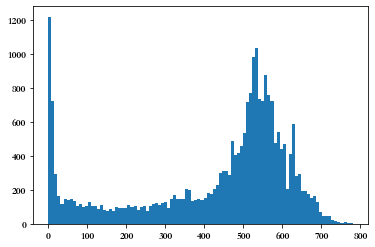

In [7]:
plt.hist(df_temp1['min'],100);
plt.savefig(os.path.join(file_path,  'min.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
df_temp1['min'].describe()

# 用户标签汇总

In [32]:
fig_path = os.path.join(file_path,'fig')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

In [46]:
list1 = ['customer_id','type','tag_flag','freq','risk','monetary']
df_reg = load_data_from_pickle(file_path, '注册未申请.pkl')
df_reg['tag_flag'] = df_reg['idcard_pass_flag'].apply(lambda x:'验证身份信息' if x =='true' else '未验证身份信息')
df_reg['last_days'] = df_reg.apply(lambda x:(pd.to_datetime('2020-02-18') - x['create_time']).days if x['update_time'] ==pd.to_datetime('1970-01-01 00:00:00')
                               else (pd.to_datetime('2020-02-18') - x['update_time']).days, axis = 1)
df_reg['freq'] = df_reg['last_days'].apply(lambda x: '活跃' if x<=30 else '不活跃')
df_reg['risk'] = 0
df_reg['monetary'] = 0
print('!!!')
df_apply = load_data_from_pickle(file_path,'申请未放款.pkl')
df_apply['type'] = '申请未放款'
df_apply['risk'] = 0
df_apply['monetary'] = 0
df_new = load_data_from_pickle(file_path,'新用户.pkl')
df_new['type'] = '新客户'
df_new['risk'] = 0
df_new['monetary'] = 0
df_old = load_data_from_pickle(file_path, '老用户.pkl')
df_old['type'] = '老客户'
df_tag_all = pd.concat([df_reg[list1],df_apply[list1],df_new[list1] ,df_old[list1]], axis = 0)
save_data_to_pickle(df_tag_all,file_path,'所有标签数据.pkl')
df_tag_all.shape

!!!


(3254826, 6)

In [ ]:
df_temp2 = df_reg[df_reg['freq']=='不活跃']
plt.hist(df_temp2['last_days'],bins=300)
plt.xlim(df_temp2['last_days'].min(),df_temp2['last_days'].max(),50)
plt.savefig(os.path.join(file_path, '注册未申请(不活跃)' + '.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)


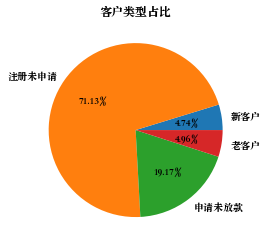

In [33]:
frame1 = pd.pivot_table(df_tag_all,index = 'type',values = 'customer_id',aggfunc = 'count')
frame1
fig = plt.figure()
plt.pie(frame1['customer_id'],labels=frame1.index,autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）
plt.title("客户类型占比")
plt.savefig(os.path.join(fig_path, '客户类型占比' + '.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show();
plt.close();



In [ ]:
list2 = ['新客户', '注册未申请', '申请未放款']
for type1 in list2:
    df_temp  = df_tag_all[df_tag_all['type'] == type1]
    frame_temp = pd.pivot_table(df_temp,index = 'tag_flag',values = 'customer_id',aggfunc = 'count')
    frame_temp
    fig = plt.figure()
    plt.pie(frame_temp['customer_id'],labels=frame_temp.index,autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）
    plt.title('%s' %type1)
    plt.savefig(os.path.join(fig_path, type1 + '.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
    plt.show();
    plt.close();

In [47]:
temp = pd.pivot_table(df_tag_all,index = ('type','tag_flag','freq','risk','monetary'),values = 'customer_id',aggfunc = 'count')
temp.to_excel(os.path.join(file_path,'table.xlsx'))
print(1)

1
